In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('diabetes.csv')

df.isna().all() # Total False
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 1. Табличное представление статистики по датасету:

In [7]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 2. Графическое представление статистики по датасету:

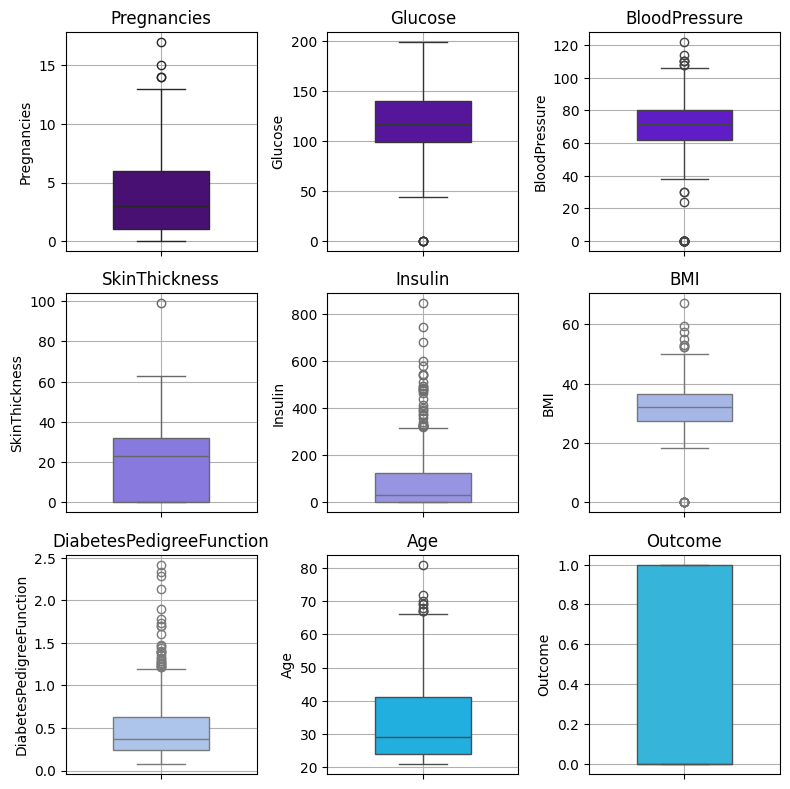

In [8]:
plt.figure(figsize=(8, 8))

parameters = df.columns
colors = ['#4B0082', '#5300B2', '#5A00E2','#7B68EE', '#8B87EF', '#9BB1F2', '#A3C3F4', '#00BFFF', '#1CC3F5',]


for i, parameter in enumerate(parameters):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df[parameter], color=colors[i], width=0.5)
    plt.title(parameter)
    plt.grid()

plt.tight_layout()
plt.show()

## 3. Разделение данных:

In [9]:
def train_test_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split_index = int((1 - test_size) * X.shape[0])
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    return X_train, X_test, y_train, y_test

# Разделение данных на обучающую и тестовую выборки
X = df.drop(columns=['Outcome'])
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 4. Реализация логистической регрессии

In [15]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000, optimization_method='gradient_descent'):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.optimization_method = optimization_method

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def log_loss(self, y_true, y_pred):
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def fit(self, X, y):
        self.m, self.n = X.shape
        self.weights = np.zeros(self.n)
        self.bias = 0

        for i in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            if self.optimization_method == 'gradient_descent':
                dw = (1 / self.m) * np.dot(X.T, (y_predicted - y))
                db = (1 / self.m) * np.sum(y_predicted - y)

                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db

            elif self.optimization_method == 'newton':
                diag_matrix = np.diag(y_predicted * (1 - y_predicted))
                hessian = np.dot(np.dot(X.T, diag_matrix), X)
                gradient = np.dot(X.T, (y_predicted - y))

                self.weights -= np.linalg.inv(hessian).dot(gradient)
                self.bias -= np.sum(y_predicted - y) / self.m

            if i % 100 == 0: 
                loss = self.log_loss(y, y_predicted)
                # print(f'Iteration {i}: Loss = {loss}')

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

In [26]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp)

def recall_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn)

def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall)


# Варьирование гиперпараметров
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.2]
num_iterations = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
optimization_methods = ['gradient_descent', 'newton']

results = []

for method in optimization_methods:
    # print(f'method: {method}')
    for lr in learning_rates:
        # print(f'learning rate: {lr}')
        for ni in num_iterations:
            # print(f'ni: {ni}')
            model = LogisticRegression(learning_rate=lr, num_iterations=ni, optimization_method=method)
            model.fit(X_train.values, y_train.values)
            y_pred = model.predict(X_test.values)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(precision, recall)
            results.append((method, lr, ni, accuracy, precision, recall, f1))
            # print()


results_df = pd.DataFrame(results, columns=['Method', 'Learning Rate', 'Num Iterations', 'Accuracy', 'Precision', 'Recall', 'F1'])


/var/folders/64/3ps8v09x21nfjp_4yk6139_40000gn/T/ipykernel_93407/1767290144.py:11: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
/var/folders/64/3ps8v09x21nfjp_4yk6139_40000gn/T/ipykernel_93407/1767290144.py:11: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
/var/folders/64/3ps8v09x21nfjp_4yk6139_40000gn/T/ipykernel_93407/1409220327.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return tp / (tp + fp)
/var/folders/64/3ps8v09x21nfjp_4yk6139_40000gn/T/ipykernel_93407/1767290144.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [37]:
results_df

,Method,Learning Rate,Num Iterations,Accuracy,Precision,Recall,F1
0,gradient_descent,0.0001,100,0.668831,0.769231,0.172414,0.281690
1,gradient_descent,0.0001,200,0.681818,0.714286,0.258621,0.379747
2,gradient_descent,0.0001,300,0.694805,0.720000,0.310345,0.433735
3,gradient_descent,0.0001,400,0.694805,0.720000,0.310345,0.433735
4,gradient_descent,0.0001,500,0.694805,0.720000,0.310345,0.433735
...,...,...,...,...,...,...,...
95,newton,0.2000,600,0.753247,0.750000,0.517241,0.612245
96,newton,0.2000,700,0.753247,0.750000,0.517241,0.612245
97,newton,0.2000,800,0.746753,0.731707,0.517241,0.606061
98,newton,0.2000,900,0.746753,0.731707,0.517241,0.606061


In [38]:
results_df.describe()

,Learning Rate,Num Iterations,Accuracy,Precision,Recall,F1
count,100.00000,100.000000,100.000000,93.000000,100.000000,93.000000
mean,0.06222,550.000000,0.683896,0.683899,0.485862,0.547677
std,0.07881,288.675135,0.105571,0.135300,0.235936,0.119886
min,0.00010,100.000000,0.370130,0.372549,0.000000,0.096774
25%,0.00100,300.000000,0.629870,0.647059,0.357759,0.540284
50%,0.01000,550.000000,0.727273,0.731707,0.517241,0.587413
75%,0.10000,800.000000,0.753247,0.760000,0.534483,0.612245
max,0.20000,1000.000000,0.785714,0.837838,0.982759,0.652632


In [48]:
results_df.head()

,Method,Learning Rate,Num Iterations,Accuracy,Precision,Recall,F1
0,gradient_descent,0.0001,100,0.668831,0.769231,0.172414,0.281690
1,gradient_descent,0.0001,200,0.681818,0.714286,0.258621,0.379747
2,gradient_descent,0.0001,300,0.694805,0.720000,0.310345,0.433735
3,gradient_descent,0.0001,400,0.694805,0.720000,0.310345,0.433735
4,gradient_descent,0.0001,500,0.694805,0.720000,0.310345,0.433735


In [66]:
newton_results = results_df[results_df['Method'] == 'newton']
# newton_results = newton_results[newton_results['Learning Rate'] != 0.2]
newton_results.head()

,Method,Learning Rate,Num Iterations,Accuracy,Precision,Recall,F1
50,newton,0.0001,100,0.753247,0.794118,0.465517,0.586957
51,newton,0.0001,200,0.785714,0.837838,0.534483,0.652632
52,newton,0.0001,300,0.772727,0.794872,0.534483,0.639175
53,newton,0.0001,400,0.766234,0.789474,0.517241,0.625000
54,newton,0.0001,500,0.753247,0.750000,0.517241,0.612245


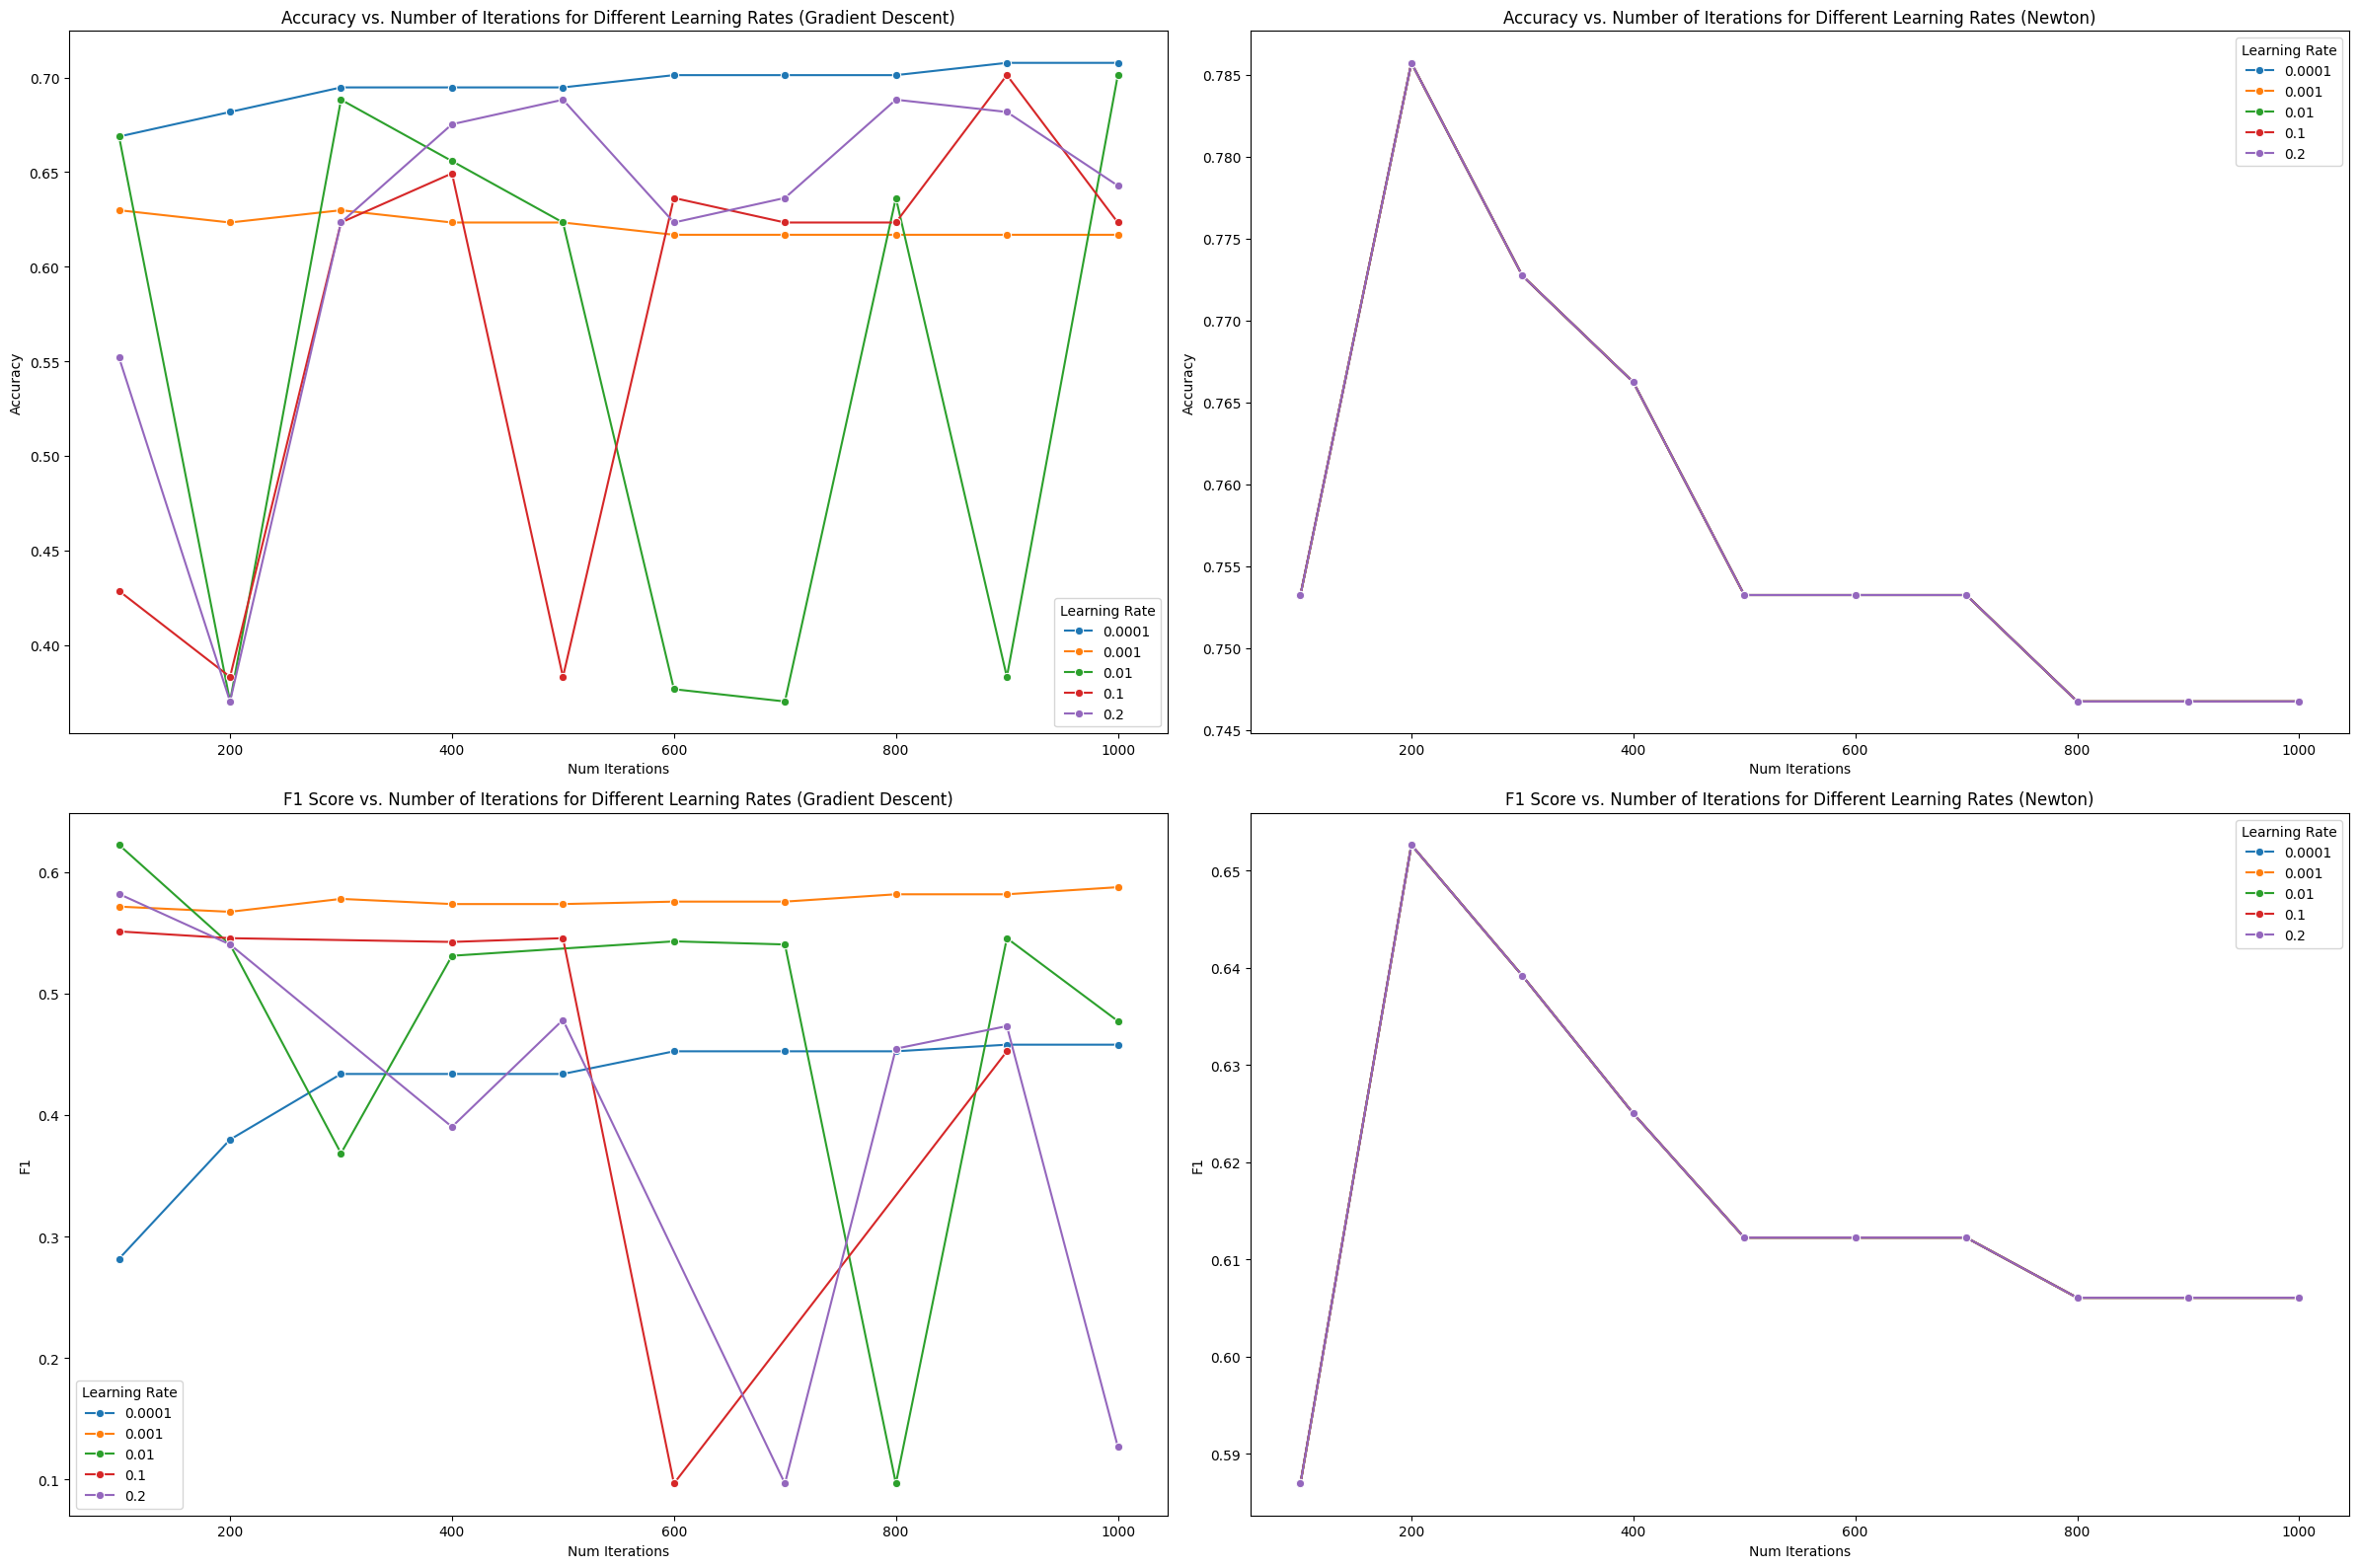

Best parameters: Learning Rate = 0.0001, Num Iterations = 200, Method = newton
Best F1 Score: 0.6526315789473685
Best Precision: 0.8378378378378378, Best Recall: 0.5344827586206896, Best Accuracy: 0.7857142857142857


In [71]:
# Визуализация результатов для Accuracy
fig, axes = plt.subplots(2, 2, figsize=(24, 16))

sns.lineplot(data=results_df[results_df['Method'] == 'gradient_descent'], x='Num Iterations', y='Accuracy', hue='Learning Rate', marker='o', palette='tab10', ax=axes[0, 0])
axes[0, 0].set_title('Accuracy vs. Number of Iterations for Different Learning Rates (Gradient Descent)')

sns.lineplot(data=newton_results, x='Num Iterations', y='Accuracy', hue='Learning Rate', marker='o', palette='tab10', ax=axes[0, 1])
axes[0, 1].set_title('Accuracy vs. Number of Iterations for Different Learning Rates (Newton)')

# Визуализация результатов для F1-Score
sns.lineplot(data=results_df[results_df['Method'] == 'gradient_descent'], x='Num Iterations', y='F1', hue='Learning Rate', marker='o', palette='tab10', ax=axes[1, 0])
axes[1, 0].set_title('F1 Score vs. Number of Iterations for Different Learning Rates (Gradient Descent)')

sns.lineplot(data=newton_results, x='Num Iterations', y='F1', hue='Learning Rate', marker='o', palette='tab10', ax=axes[1, 1])
axes[1, 1].set_title('F1 Score vs. Number of Iterations for Different Learning Rates (Newton)')

plt.tight_layout()
plt.show()

# Выводы
best_params = results_df.loc[results_df['F1'].idxmax()]
print(f"Best parameters: Learning Rate = {best_params['Learning Rate']}, Num Iterations = {best_params['Num Iterations']}, Method = {best_params['Method']}")
print(f"Best F1 Score: {best_params['F1']}")
print(f"Best Precision: {best_params['Precision']}, Best Recall: {best_params['Recall']}, Best Accuracy: {best_params['Accuracy']}")